In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# import needed libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Loading dataset and splitting to validation and training

In [3]:
DATA_DIR = '/kaggle/input/validaion-if-a-real-posm/dataset_for_img_validation/' # dir with dataset imgs

CLASSES = [
    'good',
    'trash'
]

NUM_CLASSES = len(CLASSES)

IMAGE_RESIZE = 224
img_size = IMAGE_RESIZE
OBJECTIVE_FUNCTION = 'binary_crossentropy'
LOSS_METRICS = ['recall', 'precision']

NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 79
STEPS_PER_EPOCH_VALIDATION = 20
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 16

In [4]:
# Uploading imgs and add some augmentation
X, y = [], []
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range= 20,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(DATA_DIR, target_size=(img_size, img_size), batch_size=BATCH_SIZE_TRAINING, subset='training', shuffle=True)

# validation_generator = train_datagen.flow_from_directory(DATA_DIR, target_size=(img_size, img_size), batch_size=BATCH_SIZE_VALIDATION, subset='validation', shuffle=True)

Found 1562 images belonging to 2 classes.


In [5]:
X, y = next(train_generator)

In [6]:
print(X.shape)
print(y.shape)

(64, 224, 224, 3)
(64, 2)


In [7]:
print("Classes as index:", train_generator.class_indices)

Classes as index: {'good': 0, 'trash': 1}


# Creating and compiling the model

In [8]:
base_model = tf.keras.applications.ResNet101(weights = 'imagenet', include_top = False)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
len(base_model.layers)

345

In [11]:
# take base model convolution layers from resnet
x = base_model.output
# compress incoming feature maps from resnet layers
x = GlobalAveragePooling2D()(x)
# and add fresh top of dense layers
# each node will distinguish between 1024 or 512 features
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = tf.keras.layers.Dense(2, activation = 'softmax')(x)
# create new model from both components
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model.summary()

In [12]:
# lock all resnet layers 1-174
for layer in model.layers[:345]:
    layer.trainable = False
# the new dense layers have to be trainable
for layer in model.layers[345:]:
    layer.trainable = True

In [13]:
adam_optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["precision","recall"])

In [14]:
fit_history1 = model.fit(
    train_generator,
    batch_size=BATCH_SIZE_TRAINING,
    epochs = 20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716021319.371141     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716021319.452879     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/25 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: 12.0096 - precision: 0.5112 - recall: 0.5112

W0000 00:00:1716021339.181337     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 6.8428 - precision: 0.5117 - recall: 0.5117
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 790ms/step - loss: 0.6644 - precision: 0.6064 - recall: 0.6064
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 787ms/step - loss: 0.6189 - precision: 0.6620 - recall: 0.6620
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 785ms/step - loss: 0.6020 - precision: 0.6841 - recall: 0.6841
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 778ms/step - loss: 0.5845 - precision: 0.7190 - recall: 0.7190
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 786ms/step - loss: 0.5932 - precision: 0.6997 - recall: 0.6997
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 802ms/step - loss: 0.6383 - precision: 0.6639 - recall: 0.6639
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 813ms/step - loss: 0.5720 - precision: 0.7113 - recall: 0.7113
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 782ms/step - loss: 0.6056 - precision: 0.6838 - recall: 0.6838
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 794ms/step - loss: 0.5485 

In [ ]:
fit_history1.history

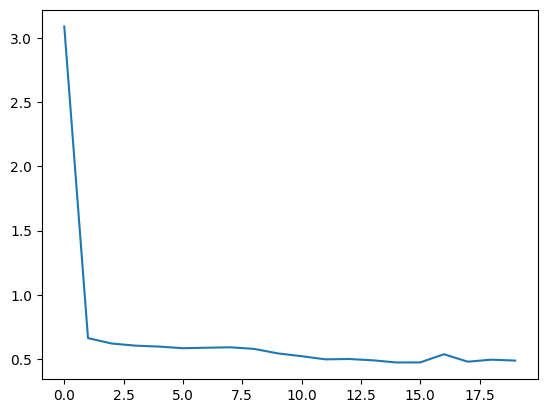

In [15]:
plt.plot(fit_history1.history['loss'])

In [19]:
for layer in model.layers:
    layer.trainable = True

In [20]:
adam_optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["recall", "precision", "AUC"])

In [21]:
fit_history2 = model.fit(
    train_generator,
    batch_size=BATCH_SIZE_TRAINING,
    epochs = 30,
)

Epoch 1/30


W0000 00:00:1716022036.958122     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/25 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - AUC: 0.4877 - loss: 6.8841 - precision: 0.4887 - recall: 0.4887

W0000 00:00:1716022113.819736     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - AUC: 0.4989 - loss: 6.0883 - precision: 0.5032 - recall: 0.5032
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.7040 - loss: 0.7902 - precision: 0.6701 - recall: 0.6701
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 989ms/step - AUC: 0.7262 - loss: 0.6355 - precision: 0.6695 - recall: 0.6695
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - AUC: 0.7063 - loss: 0.6025 - precision: 0.6504 - recall: 0.6504
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - AUC: 0.7795 - loss: 0.5656 - precision: 0.7221 - recall: 0.7221
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.6950 - loss: 0.8322 - precision: 0.6363 - recall: 0.6363
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - AUC: 0.7425 - loss: 0.6334 - precision: 0.6733 - recall: 0.6733
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - AUC: 0.7976 - loss: 0.5468 - precision: 0.7190 - recall: 0.7190
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.7957 - loss: 0.5695 

# Check

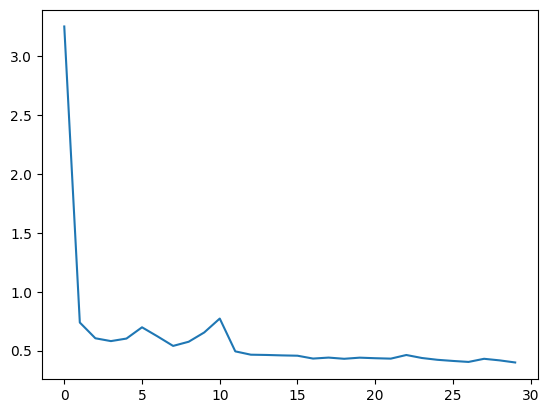

In [22]:
plt.plot(fit_history2.history['loss'])

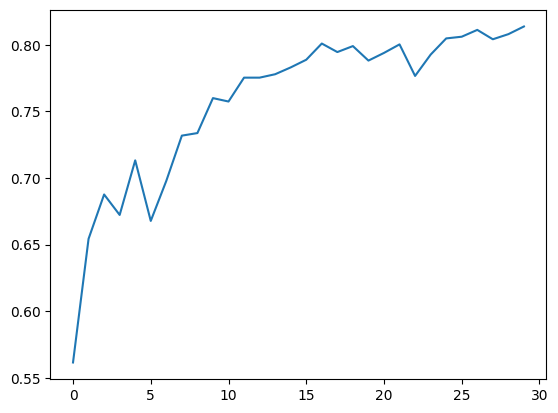

In [23]:
plt.plot(fit_history2.history['recall'])

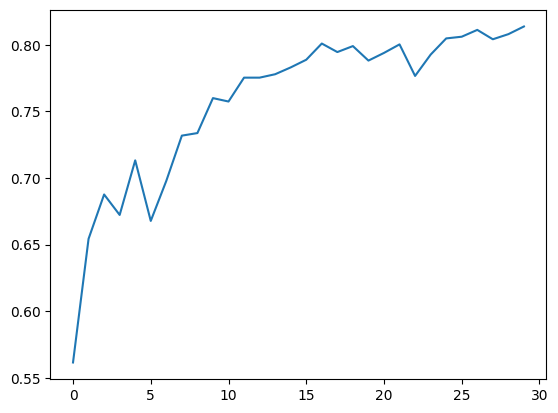

In [24]:
plt.plot(fit_history2.history['precision'])

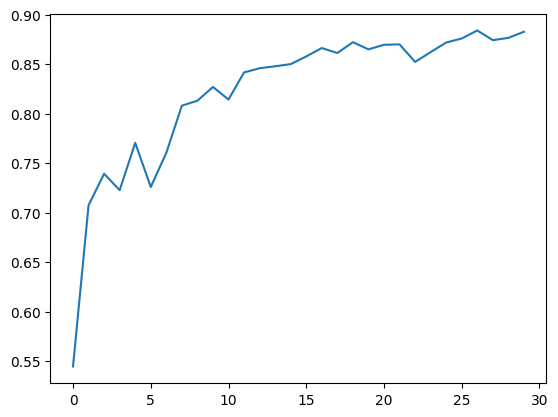

In [25]:
plt.plot(fit_history2.history['AUC'])

In [28]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range= 20,
    horizontal_flip=True,
    vertical_flip=True,
)

test_generator = test_datagen.flow_from_directory('/kaggle/input/posm-or-trash/binary_ds', target_size=(img_size, img_size), batch_size=90, shuffle=True)


Found 306 images belonging to 2 classes.


In [29]:
model.evaluate(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - AUC: 0.6191 - loss: 0.6782 - precision: 0.6271 - recall: 0.6271


W0000 00:00:1716024569.983678     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.6739498376846313,
 0.6176470518112183,
 0.6176470518112183,
 0.6204878687858582]

In [30]:
res_prediction = model.predict(X[9:11])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


W0000 00:00:1716024683.862834     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


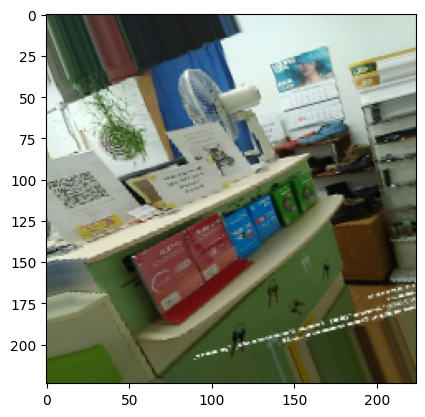

In [42]:
plt.imshow(X[9])

In [43]:
res_prediction[0]

array([0.5249888 , 0.47501123], dtype=float32)

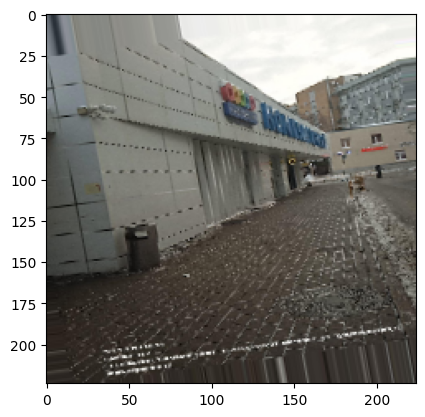

In [39]:
plt.imshow(X[10])

In [40]:
res_prediction[1]

array([0.6550625, 0.3449376], dtype=float32)

# Export

In [45]:
model.save('/kaggle/working/final_resnet_transfer.keras') 

In [ ]:
pred_model = keras.models.load_model('/kaggle/working/final_resnet_transfer.keras')